In [1]:
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ml_utils
from sklearn.preprocessing import StandardScaler

# Support Vector Machines

Support vector machines are really common and versitile linear model - they can do classification and regression, though we normally look at them through the lens of classification, as that is their most common application.

SVM are easiest to understand through looking at some example visualizations.

<b>Note:</b> This notebook uses several examples of data generation, with is pretty common for examples. SKlearn has sevreal "make..." functions that can generate random data that fits certain patterns. 

In [2]:
# Load Iris Dataset
df = ml_utils.sklearn_to_df(datasets.load_iris())
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


We will also simplify the data a little, so we can picture the support vectors. We want only 2 features to plot on a scatter plot. 

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

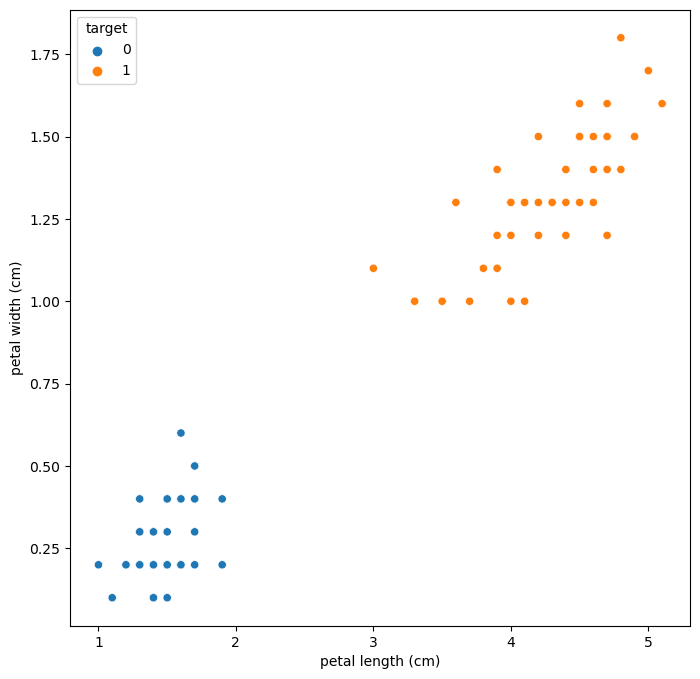

In [3]:
d = df.drop(columns={"sepal length (cm)", "sepal width (cm)"})
d = d[d["target"] <= 1]
x_lab = "petal length (cm)"
y_lab = "petal width (cm)"

sns.scatterplot(data=d, y=y_lab, x=x_lab, hue="target")

### Separate These

After we've plotted the data we can intuitively divide the groups - we could sketch a line right through the middle that divides the two groups. These groups are linearly separable, they can be separated by a line. In fact they could be separated by several different lines. Any of these red lines does the job of dividing the two groups.

![SVM Separation](images/svm_bad.png "SVM" )

We can show a separation that the SVM determines by fitting an SVM model to the data, and doing a bunch of plotting work to make it pretty. SVM looks for the separation line (called a hyperplane) that maximizes that margin between the two classes. The SVM is called a large margin classifier because it tries to maximize the margin between the two classes.

![Margin](images/margin.webp "Margin" )

<b>Note:</b> Things like this little plotting function may be useful to save in something like your utility file, then you could use it in other notebooks without needing to re-write it or look something up. 

In [4]:
#SVM Stuff
#Note: this stuff is just to draw the lines, you don't always need all this. 
#Note 2: Plotting this stuff is a pain! There's a library that we'll look at in a bit that makes it easier. 
def plot_svc_decision_boundary(svm_clf, xmin, xmax, color="black"):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "-", linewidth=2, color=color)
    plt.plot(x0, gutter_up, "--", linewidth=2, color=color)
    plt.plot(x0, gutter_down, "--", linewidth=2, color=color)

Generate fitted Support Vector Classifier and plot the separation. 

In [5]:
import sys
large_value = sys.maxsize

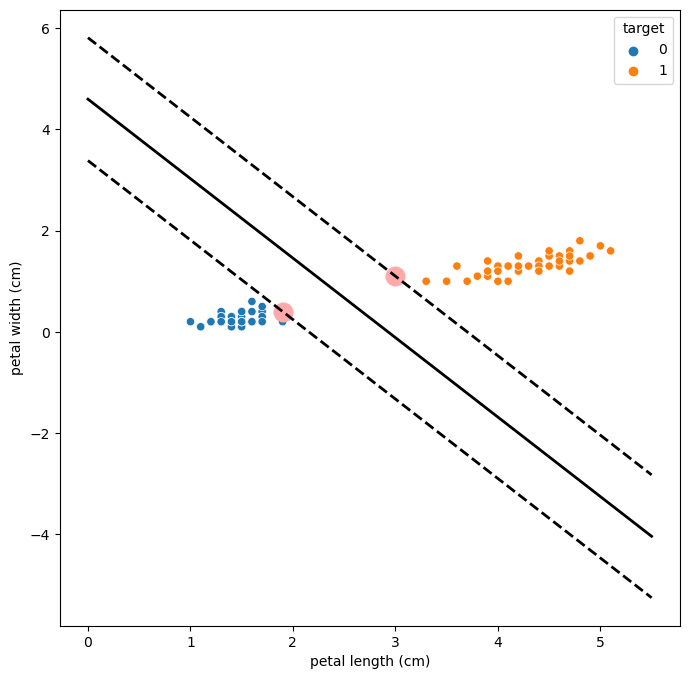

In [6]:
y = d["target"]
X = d.drop(columns={"target"})
#svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf = SVC(kernel="linear", C=float(large_value))
svm_clf.fit(X, y)

sns.scatterplot(data=d, y=y_lab, x=x_lab, hue="target")
plot_svc_decision_boundary(svm_clf, 0, 5.5)

## SVM Separation

The above result shows how SVM works in one picture - it draws a line to separate the two groups, and chooses the place for that line that maximizes the width of the dotted lines - the decision boundaries. 

In this example the two classes are very separate, so the SVM can create a nice wide boundary splitting A and B. Note that if we had a bunch more data that was outside of the boundary, it wouldn't change the results - only things that impact the decision boundary "matter" in making the model. 

What we have is a hard margin classification - there is a strict division between classes. 

### The Hyperplane

The hyperplane is the term for that line generated between the two datasets. What is it? It is a linear function in dimensions n-1 that splits the groups. For 2D examples, it is a line. For 3 dimensions, it is a plane. For greater dimensions, it gets hard to picture.

![SVM Hyperplane](images/svm_plane.png "SVM Hyperplane" )

The SVM algorithm tries to maximize this boundary size - this should intuitively make sense. The wider the gulf between the two classes, the more confident we can be in separating an item into one group or another. The items that are close to the boundaries are the "borderline" items that are close and could go either way - we want to minimize those items. The hyperplane itself is simply a linear model (a line for 2D data), just like a logistic regression:

![Hyperplane](images/hyperplane.webp "Hyperplane")

Where w is the vector of weights, X is the vector of features, and b is the bias.

### Support Vectors

The points that define the boundaries, that are intersected by the dashed lines, are the nsamesake support vectors. We don't have a clear history of where the "machine" part of the name comes from. 

![SVM Support Vectors](images/support_vectors.webp "SVM Support Vectors" )

### SVM Soft Margins

But what if there isn't a clear division between the groups? Many to most things we want to classify don't have such a severe and simple separation of classes. With hard margins, even one outlier that was "on the other side" could mess things up. To deal with this we can make our model softer, or allow it to deal with some amount of overlap in our classes. This is (obviously) soft margin classification. 

This is done by setting a hyperparameter C in the model: 
<ul>
<li> High C values minimize overlap, but result in smaller boundaries. 
<li> Low C values allow for more overlap, but have wider boundaries. 
</ul>

In general higher C will make models more fitted, lower will make them more general. Like most other hyperparameters, we need to tune this to get the best results. The more distinct the classes, the more aggressive we can be with creating strict boundaries between the classes; the less distinct the classes, the more overlap we need to allow for the model to work well. 

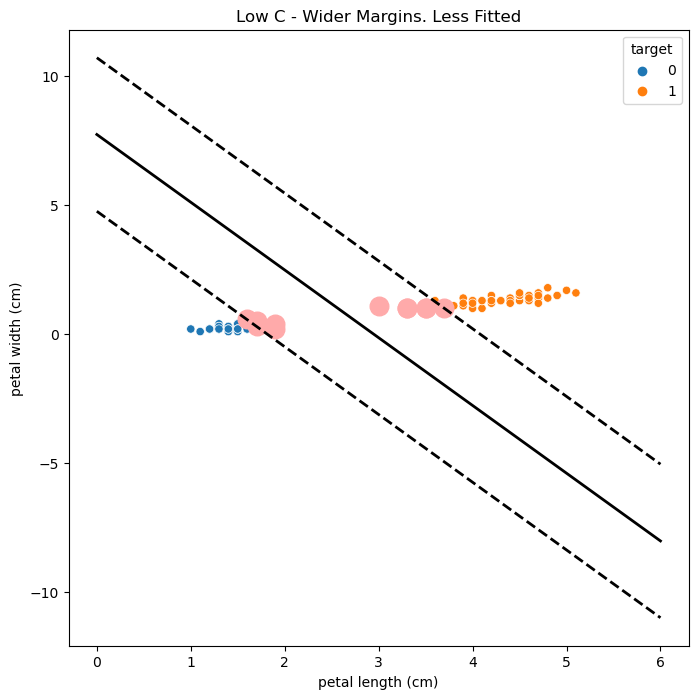

In [7]:
d2 = df.drop(columns={"sepal length (cm)", "sepal width (cm)"})
d2 = d2[d2["target"] != 2]
y2 = d2["target"]
X2 = d2.drop(columns={"target"})

svm_wide = SVC(kernel="linear", C=float(5))
svm_wide.fit(X2, y2)
svm_nar = SVC(kernel="linear", C=float(.1))
svm_nar.fit(X2, y2)

sns.scatterplot(data=d2, y=y_lab, x=x_lab, hue="target").set(title="Low C - Wider Margins. Less Fitted")
plot_svc_decision_boundary(svm_nar, 0, 6)



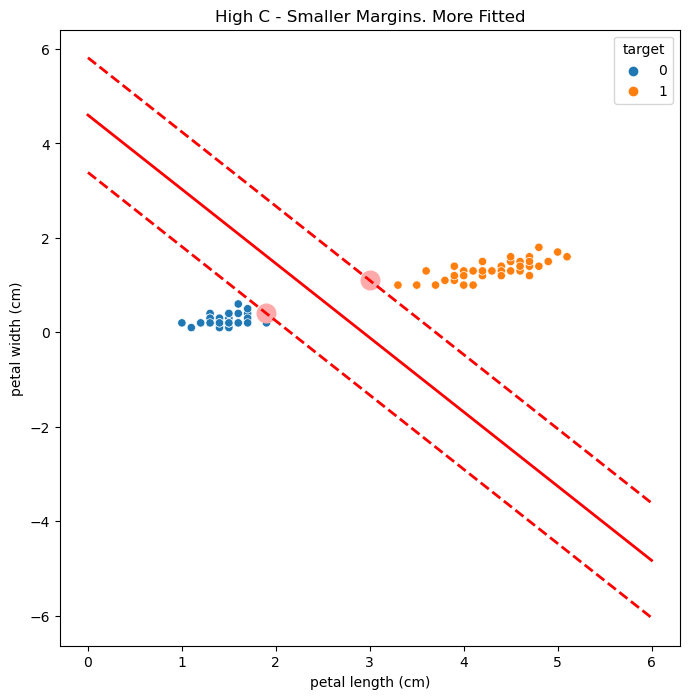

In [8]:
sns.scatterplot(data=d2, y=y_lab, x=x_lab, hue="target").set(title="High C - Smaller Margins. More Fitted")
plot_svc_decision_boundary(svm_wide, 0, 6, color="red")

### SVM Loss

SVM uses a loss function called the Hinge Loss, it is a function of the distance from the decision boundary. Hinge loss can be be plotted as a function of the distance from the decision boundary, that looks like a hinge:

![Hinge Loss](images/hinge_loss.webp "Hinge Loss" )

A few things that we can note with hinge loss:
<ul>
<li> Distances from the decision boundary <b><i>can</i></b> be negative, for items that are on the wrong side of the decision boundary. A negative distance from the boundary incurs a high loss. This essentially means that we are on the wrong side of the boundary, and that the instance will be classified incorrectly.
<li> A positive distance from the boundary incurs a low loss, or no loss at all. Once we reach a certain point of "good" our loss remains flat at 0. So the only items that incur loss are those that are close to, or on the wrong side of the decision boundary. 
</ul>

So, the end result is that things that are correctly classified don't factor into the loss, and only items that are close to the boundary or on the wrong side matter for the loss calculation. Our boundary will be drawn at whatever point minimizes this loss, as we are used to with logistic regression. 

## Non Linear Separation and the Kernel Trick

The SVM we just looked at looks pretty good, as long as things are linearly separable. Unfortunately not all data is like that. 

Similarly to using a basis function to "curve" a linear regression to non-linear data, we can use the kernal argument to apply an SVM to a non linear pattern. This is sometimes called the "kernal trick" and is the key to dealing with real data, which often doesn't have nice wide spearations like we did with the sample. This works largely like the basis functions we used with linear regression - we can add a transformation to the data to make it linearly separable; or we can "allow" the model to be reshaped to fit the data.

For example, we can create some dummy data that is not very linearly separable. 

<Axes: xlabel='X1', ylabel='X2'>

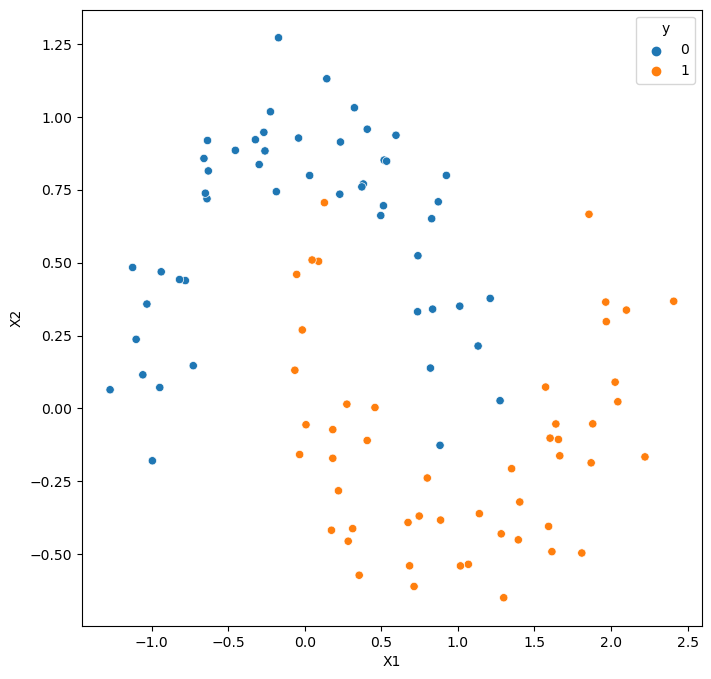

In [9]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline


X_moon, y_moon = make_moons(n_samples=100, noise=0.15, random_state=42)
d_moon = pd.DataFrame(X_moon[:,0], columns=["X1"])
d_moon["X2"] = X_moon[:,1]
d_moon["y"] = y_moon
sns.scatterplot(data=d_moon, x="X1", y="X2", hue="y")


#### Separation

These two datasets are not linearly separable. If we were to draw a curved line between them it would look kind of like a cubic polynomial. We can use a kernel in our model to incorporate that!

### Kernels

Kernels function like basis functions in linear regression. We can specify this as a hyperparameter when creating the SVM object. The choices are:
<ul>
<li> linear
<li> rbf - radial (circular)
<li> poly - polynomial
<li> sigmoid - like our sigmoid curve in linear regression. 
<li> custom - you can create a custom function to do the transformation you'd like
</ul>

Each of these will generate a different split, we want to choose one that matches our data. With these 2D examples, that isn't too hard; with real data we are probably in a guess and test with a grid search scenario. 

![SVM Kernels](images/svm_kern.png "SVM Kernels" )

Note that the linear one is fast, especially on large datasets, the others are a fair bit slower. 

In [10]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1))
    ])
poly_kernel_svm_clf.fit(X_moon, y_moon)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(coef0=1, kernel='poly'))])

### Plotting with Hyperplanes

As we've seen above, plotting these charts can be a pain, there is a library that makes it easier but it does need to be installed. The library is called mlxtend. This one isn't in the conda install stuff, you need to use pip to install it:

> pip install mlxtend

If you don't have pip, that might actually be helpful with installing things in general. It can be installed via:

> conda install pip

If you don't have this installed, it isn't really the end of the world. This visualization stuff is more for the demonstrations of how SVMs work, when using real data it is pretty hard to visualize it like this when there are >3 dimensions.

<Axes: >

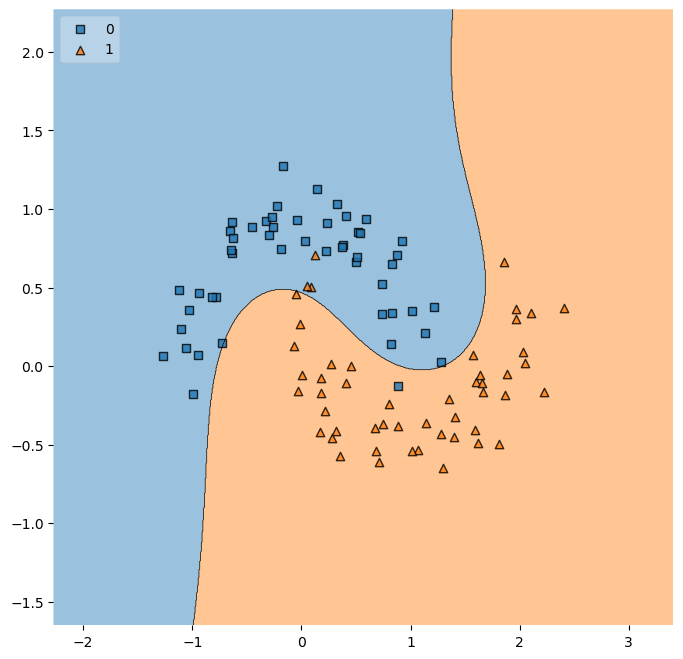

In [11]:
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X_moon, 
                      y=y_moon,
                      clf=poly_kernel_svm_clf, 
                      legend=2)

#### Radial Kernel

What if we make some data that is circular? 

<Axes: xlabel='X1', ylabel='X2'>

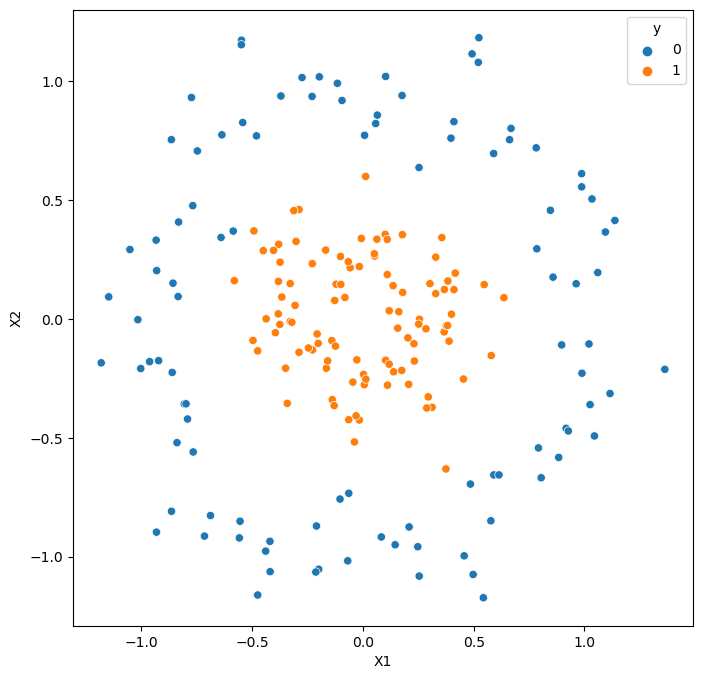

In [12]:
from sklearn.datasets import make_circles
X_cir, y_cir = make_circles(n_samples=200, noise=0.15, factor=.3)
d_cir = pd.DataFrame(X_cir[:,0], columns=["X1"])
d_cir["X2"] = X_cir[:,1]
d_cir["y"] = y_cir
sns.scatterplot(data=d_cir, x="X1", y="X2", hue="y")

This is obviously pretty difficult to imposible to separate linearly, but if we give our SVM classifier a radial kernel, it can split these two classes, probably almost perfectly (we have randomness, so each dataset is slightly different).

<Axes: >

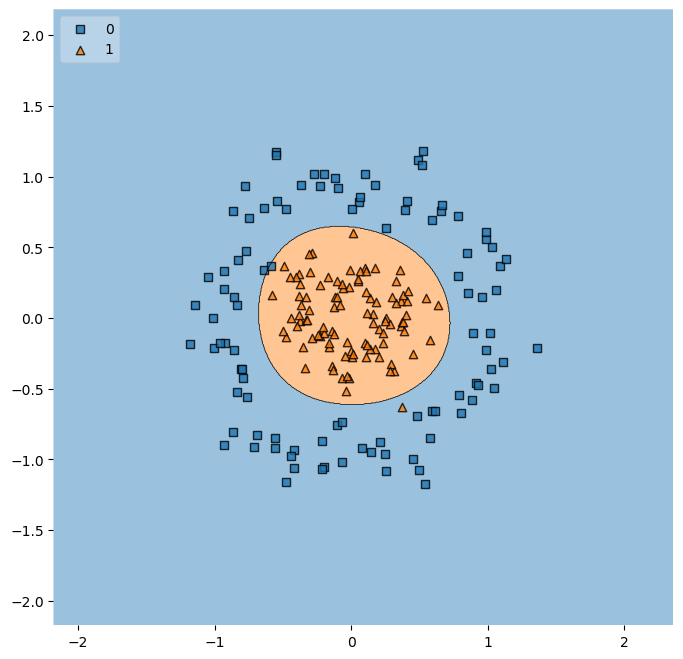

In [13]:
radial_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf"))
    ])
radial_kernel_svm_clf.fit(X_cir, y_cir)

plot_decision_regions(X=X_cir, 
                      y=y_cir,
                      clf=radial_kernel_svm_clf, 
                      legend=2)

## How Does the Kernel Trick, Trick? 

The kernel trick's magic is that it will transform our data into a higher dimension, so that we can separate it with a linear boundary - and that it'll do so without making things too computationally expensive. Once the transformation into a higher dimension takes place, we can often more easily separate the data with a linear boundary. For a simple example to get warmed up, let's look at some 1 dimensional data and a quadratic transformation.:

![1D Data](images/quad_kern.webp "1D Data" )

Here the original data on the left is hard to separate with any kind of linear plane, we need to basically slice out the middle values into one class, and leave the low and high values in the other. If we were to perform a quadratic transformation on the data, or just square each value, we change the data into the second image, which is now in 2 dimensions. Once the dimesionality is expanded, we can now separate the data with a linear boundary pretty easily. 

This is what we are always doing when applying a kernel - we explode the number of dimensions in our data, then we can use the linear separation abilities of the SVM to draw a hyperplane that can now separate the data. Since the data becomes so much more "spread" in higher dimensional space, we can often find a linear plane that does a great job of separating the data.

![Kernel Trick](images/kernel_trick.png "Kernel Trick" )

### What is a Kernel?

The kernel function is basically a mathmatical shortcut that allows us to transform our data into a higher dimension without actually having to do the transformation, hence the trick bit. The mathmatical definition of a kernel is:
<ul>
<li> K(x, y) = &lt; f(x), f(y)>
    <ul>
    <li> Here K is the kernel function.
    <li> x, y are n dimensional inputs.
    <li> f is a map from n-dimension to m-dimension space. 
    <li> &lt; x,y> denotes the dot product. usually m is much larger than n.
    </ul>
</ul>

In English? The kernel function is a function that takes two inputs, and returns a dot product of the two inputs after they have been transformed into a higher dimension. We can look at an example with real numbers, and a polynomial kernel. We can walk through a simple example to see how this works.
<ul>
<li> Suppose our kernel is a polynomial to the power of 2.
<li> Suppose our data is x = (1,2,3) and y = (4,5,6)
<li> First, we need to map our data into a higher dimension, or apply the function to each dataset. So the x is multiplied by itself, and the y is multiplied by itself. This gives us 9 dimensional data rather than 3 dimensional data.
    <ul>
    <li> f(x) -> 1,2,3,2,4,6,3,6,9
        <ul>
        <li> (1,2,3) * (1,2,3) = 1*1, 1*2, 1*3, 2*1, 2*2, 2*3, 3*1, 3*2, 3*3 = 1,2,3,2,4,6,3,6,9
        </ul>
    <li> f(y) -> 16,20,24,20,25,30,24,30,36
        <ul>
        <li> (4,5,6) * (4,5,6) = 4*4, 4*5, 4*6, 5*4, 5*5, 5*6, 6*4, 6*5, 6*6 = 16,20,24,20,25,30,24,30,36
        </ul>
    <li> <b>Dot Product:</b> &lt;f(x),f(y)> = 1*16 + 2*20 + 3*24 + 2*20 + 4*25 + 6*30 + 3*24 + 6*30 + 9*36 = 16 + 40 + 72 + 40 + 100 + 180 + 72 + 180 + 324 = 1024
    </ul>
<li> This is obviously a lot of algebra, and with a large number of dimensions, it would be a lot of work to do this set of calculations over and over. 
<li> Now we can calculate the kernel trick:
    <ul>
    <li> K(x, y) = (1*4 + 2*5 + 3*6)^2 = (4 + 10 + 18 ) ^2 = 1024
    <li> Same same, but faster. 
    </ul>
</ul>
Full derivation: https://qr.ae/pvoYg9

### Kernel Types

Each of the kernel types has a different shortcut calculation like this, and each allows for a similar expansions of dimensionality, and a similar linear separability after transformation. The table of kernel transformations is visualized up above, the definitions are:

![Kernels](images/kernels.webp "Kernels" )

In low dimensions, like our examples, we can see how this works pretty well. In higher dimensions, it is a bit harder to visualize, so it is hard to "see" which kernel may be best, we normally need to grid search them to find the optimal solution. 

## Exercise - Weird Shape

The code below will give us a random classification to classify. Try using a grid search with different kernels to see which one fits. Every run will give a different shape of data, so the right answer is random. 

<b>Note:</b> you can set the random seed in the data generation if you want to keep a static dataset each execution. 

<Axes: xlabel='X1', ylabel='X2'>

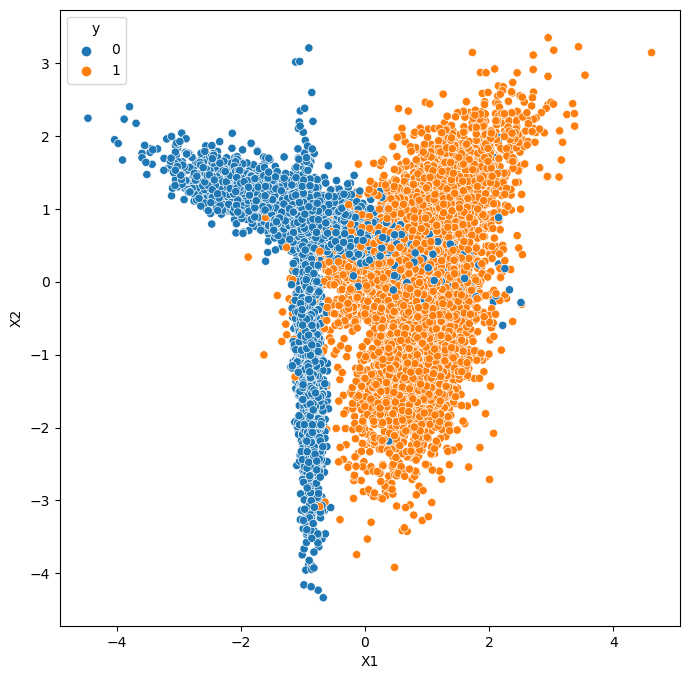

In [14]:
#Make some random data
from sklearn.datasets import make_classification
X_cla, y_cla = make_classification(n_samples=10000, n_features=2, n_redundant=0, class_sep=.9)
d_cla = pd.DataFrame(X_cla[:,0], columns=["X1"])
d_cla["X2"] = X_cla[:,1]
d_cla["y"] = y_cla
sns.scatterplot(data=d_cla, x="X1", y="X2", hue="y")

In [15]:
# Make the outcome of this be y_train and train_preds to see the ROC thing below. 

### ROC Curves

In addition to our friend the confusion matrix, ROC curves are another useful way to visualize classifier performance. ROC stands for Receiver Operating Characteristic and it plots the true positive rate (recall) against the false positive rate (1-specificity). The way we read the curve is pretty simple, the faster the line for our model pushes towards the top left corner, the better it is. What that is measuring is effectively that the model is able to "accumulate" true positives "before" false positives - or the ratio of TP to FP is high, which is what we want. 

The dotted diagonal line represents random chance, and the line for our model represents the improvement over random chance. The random chance line shows that if we were just guessing, TP and FP would be equally likely, so we'd climb to getting 100% of the TP getting an equal amount of FP. The farther up our line is, the more TP we get "for each" FP that the model predicts. 

There isn't a all-in-one chart in seaborn that can print a visualization of a ROC curve in one step, which is annoying. This is the type of problem that is both common and relatively easy, so the internet offers us a million different implementations that we can borrow from if we don't want to make a linechart by hand. 

<b>Note:</b> this also may be something useful for your utility file. 

In [16]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
plot_roc_curve(fpr,tpr)

NameError: name 'y_train' is not defined

### ROC Score

We can also get the ROC score, which measures the area under the curve (AUC). The score goes between 0 and 1, the higher the better. If it was 1, that would indicate that we get all the true positives, with no false positives, which is pretty good!. 

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, train_preds)

0.9196176685255839

## SVM and Multinomial Classifications

Like linear regression, SVMs are a 2 class thing by default. In an SVM classifier we can choose between One vs One, or One vs Rest, with OVR being the default. 

We can try it for the flower example, with all the data. This has 3 output classes and 4 features. We can't really visualize it in 4D very easily but we can make the classification. If we take a peek at the scatterplots and think about the OVR decisions, I'd suspect going in that we'd be able to do this pretty accurately. If we visualize one set vs the other two, each scatter plot looks like we can come pretty close to separating those groups linearly - they are reasonably distinct from each other. Let's see the results...

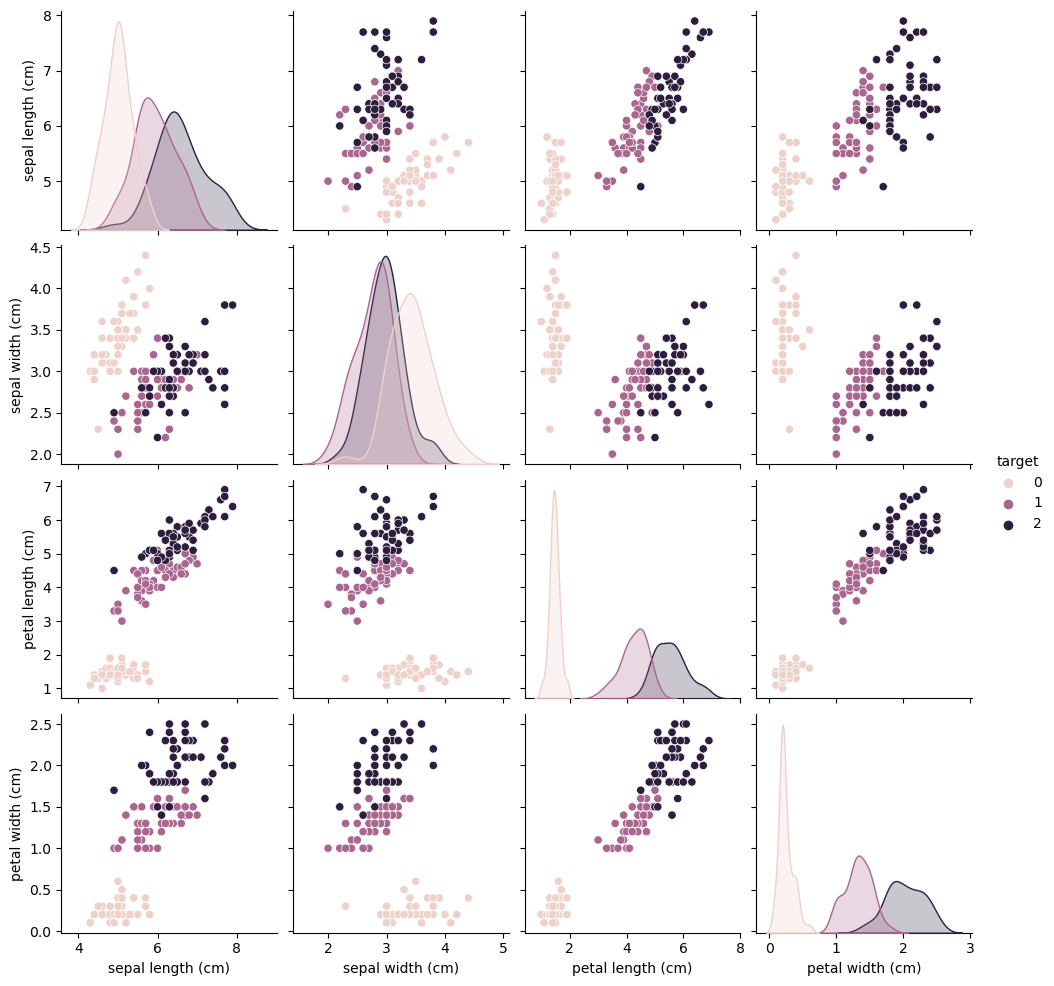

In [ ]:
sns.pairplot(data=df, hue="target")

## Exercise - Multiclass SVM

Use the flower dataset and try to classify it with an SVM. Grid search the OVR and OVO methods, along with a couple other options, to get a well fitted model. The hpyerparameter for the multiclass method is "decision_function_shape" and the options are "ovo" and "ovr".

Train Score: 0.9642857142857143
Test Score: 1.0
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=4, decision_function_shape='ovo', kernel='linear'))])


Visualize some results. 

<Axes: >

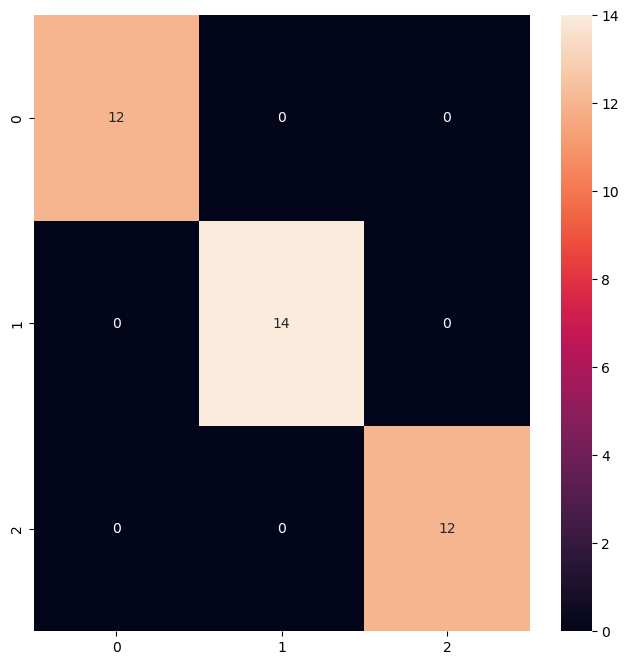